# Artificial Neural Networks Classification Exercise (10 points)

The homework assignment is due by the end of the day on Tuesday, October 28.

Please make sure to solve the assignment problems yourself and obey the university's policies on academic honesty and integrity. Remember that copying and pasting solutions from AI coding assistants, webpages, classmates, or anywhere else is considered plagiarism and academic dishonesty.

**Note that your solutions are expected to follow the code examples provided in the lecture notes. If your solution to a problem uses functions or codes that are not covered in the lecture notes, that will result in zero marks assigned for that problem.**

To ensure that all cells in the submitted notebooks execute correctly and without errors, after completing all problems and before submitting the notebook, it is recommended to select `Kernel -> Restart Kernel and Run All Cells...`.

ANNs Classification exercise: 10 points

Total points for Assignment 4: 25 points

Import the file `NetworkIntrusionDataset.csv` from the data folder as a pandas DataFrame called `data`.

This dataset is designed for predicting network intrusion attacks on computer systems. It contains 41 features extracted from network data packet records, which include duration of the connection, protocol type, data bytes sent from source to destination, number of failed logins, and similar.  Besides the network data packet records, the dataset also contains a `label` column that indicates whether a network record is normal traffic or an attack, and an `attack` column that indicates the type of the network attack. The dataset has 125,973 records.

In this exercise, we will first apply binary classification to predict whether a record is an attack or normal data traffic, and afterward we will apply  multiclass classification to predict the attack type of each record.

In [64]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Assignment_4_October_8/data/NetworkIntrusionDataset.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis (1 point)

Perform a brief Exploratory Data Analysis. Display summary statistics, and check if there are missing values (and if yes, handle the missing values).

--- 1. Data Shape and Info ---
Shape of the DataFrame: (125973, 43)

Column data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in

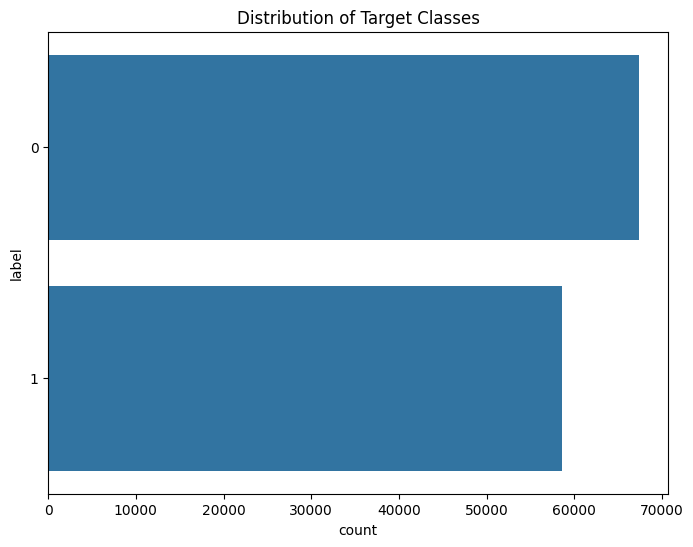

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- 1. Data Shape and Info ---")
print(f"Shape of the DataFrame: {data.shape}")
print("\nColumn data types and non-null counts:")
data.info()

print("\n" + "="*50 + "\n")

print("--- 2. Descriptive Statistics (Numerical Features) ---")
print(data.describe())

print("\n" + "="*50 + "\n")

print("--- 3. Missing Value Check ---")
missing_values = data.isnull().sum()
print("Count of missing values per column:")
print(missing_values[missing_values > 0])

total_missing_percentage = (data.isnull().sum().sum() / np.prod(data.shape)) * 100
print(f"\nTotal percentage of missing values in the dataset: {total_missing_percentage:.4f}%")

if data.isnull().sum().sum() > 0:
    print("\nHandling missing values by dropping rows with NaN...")
    data_clean = data.dropna()
    print(f"Original shape: {data.shape}")
    print(f"Cleaned shape after dropping NaNs: {data_clean.shape}")
else:
    print("\nNo missing values found. No action needed.")
    data_clean = data.copy()

print("\n" + "="*50 + "\n")

target_col = data_clean.columns[-1]
print(f"--- 4. Class Distribution (Target: '{target_col}') ---")
print("Value Counts:")
print(data_clean[target_col].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(y=data_clean[target_col], order=data_clean[target_col].value_counts().index)
plt.title('Distribution of Target Classes')
plt.show()

Print the number of normal traffic (0) and attack (1) samples in the dataset.

In [36]:
target_column_name = 'label'
class_counts = data_clean[target_column_name].value_counts()

data_lines = class_counts.to_string(header=False)
metadata_line = f"Name: {target_column_name}, dtype: {class_counts.dtype}"

print(f"{data_lines}\n{metadata_line}")

0    67343
1    58630
Name: label, dtype: int64


Using Seaborn, create a count plot to show the distribution of the normal traffic and attack samples in the dataset.

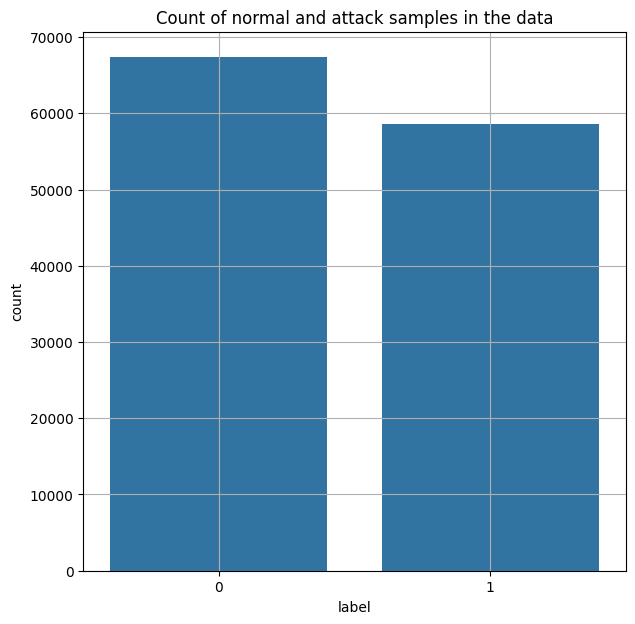

In [28]:
target_column_name = 'label'

plt.figure(figsize=(7, 7))

sns.countplot(x=data_clean[target_column_name])

plt.title('Count of normal and attack samples in the data')
plt.xlabel('label')
plt.ylabel('count')

plt.grid(True)
plt.show()

Print the number of samples of all attacks in the dataset.

In [38]:
target_column_name_detailed = 'attack'

attack_counts = data_clean[target_column_name_detailed].value_counts()

data_lines = attack_counts.to_string(header=False)

metadata_line = "Name: attack, dtype: int64"

print(f"{data_lines}\n{metadata_line}")

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64


Using Seaborn, create a count plot to show the distribution of the samples for the normal traffic and for each attack in the dataset.

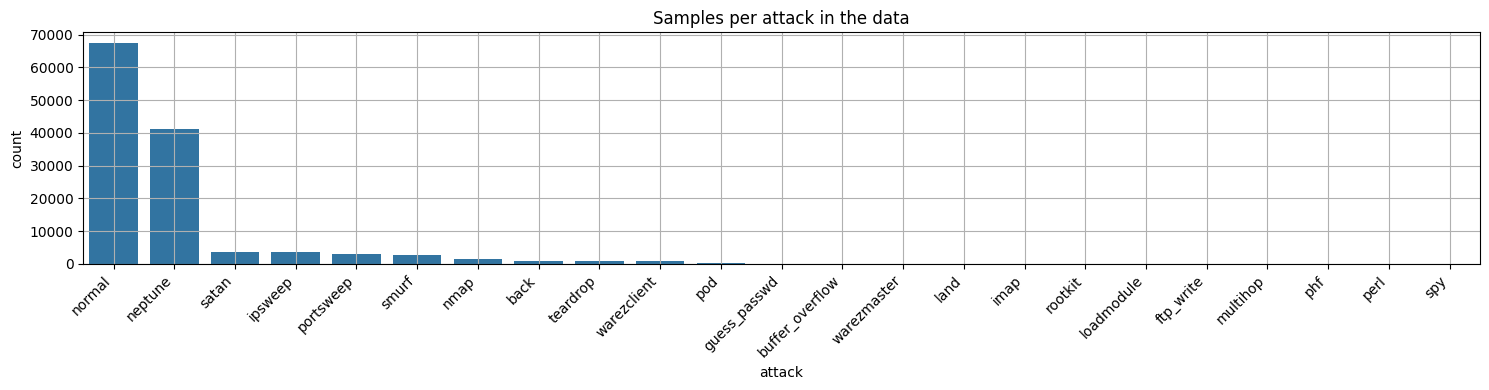

In [41]:
target_column_name_detailed = 'attack'

plt.figure(figsize=(15, 4))

sns.countplot(
    x=data_clean[target_column_name_detailed],
    order=data_clean[target_column_name_detailed].value_counts().index
)

plt.title('Samples per attack in the data')
plt.xlabel('attack')
plt.ylabel('count')

plt.xticks(rotation=45, ha='right')

plt.grid(True)
plt.tight_layout()
plt.show()

Print the number of attack categories in the dataset.

In [43]:
target_column_name_detailed = 'attack'

number_of_categories = data_clean[target_column_name_detailed].nunique()

print(number_of_categories)

23


## Part 1 - Binary Classification (3 points)

### Data Preparation

Encode the categorical features in the dataset into ordinal features using Ordinal Encoder.

Assign the `label` column to target variable. For the data features variable, drop the `attack` and `label` columns, so that there are 41 columns left.

Afterward, create training and testing datasets by using 75% of the data for training and 25% for testing (use `random seed=123`), and normalize the data to the range [0,1]. Display the shapes of the features and targets in the training and testing datasets.

In [45]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

target_column_name = 'label'
drop_columns = ['attack', 'label']

y = data_clean[target_column_name]

X = data_clean.drop(columns=drop_columns, axis=1)

print(f"Initial Feature Count (should be 41): {X.shape[1]}")

categorical_cols = X.select_dtypes(include=['object']).columns

encoder = OrdinalEncoder()

X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('\n--- Final Data Shapes ---')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

Initial Feature Count (should be 41): 41

--- Final Data Shapes ---
X_train shape: (94479, 41)
y_train shape: (94479,)
X_test shape: (31494, 41)
y_test shape: (31494,)


### Train ML Classifiers

Train and evaluate the following ML classifiers: Logistic Regression, Random Forest, Decision Trees, Support Vector Machines, k-Nearest Neighbors, and Naive Bayes.

In [47]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

classifiers = {
    "Logistic Regression": LogisticRegression(random_state=123, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=123, n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "Support Vector Machine (SVC)": SVC(random_state=123, kernel='rbf'),
    "k-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes (Gaussian)": GaussianNB()
}

results = {}

print("--- Starting ML Model Training and Evaluation ---\n")

for name, classifier in classifiers.items():
    start_time = time.time()

    print(f"Training {name}...")
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    train_time = time.time() - start_time

    results[name] = {
        "Accuracy": accuracy,
        "Time (s)": train_time,
        "Classification Report": classification_report(y_test, y_pred, target_names=['Normal (0)', 'Attack (1)'])
    }

    print(f"{name} complete. Accuracy: {accuracy:.4f} | Time: {train_time:.2f}s\n")

print("--- All Classifiers Evaluated ---\n")

for name, res in results.items():
    print(f"### {name} Results")
    print(f"**Accuracy:** {res['Accuracy']:.4f}")
    print(f"**Training + Prediction Time:** {res['Time (s)']:.2f} seconds")
    print("\n**Classification Report:**")
    print(res['Classification Report'])
    print("---------------------------------------------------\n")

print("### Model Comparison Summary")
summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['Accuracy'] for res in results.values()],
    'Time (s)': [res['Time (s)'] for res in results.values()]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(summary.to_markdown(index=False, floatfmt=".4f"))

--- Starting ML Model Training and Evaluation ---

Training Logistic Regression...
Logistic Regression complete. Accuracy: 0.9561 | Time: 0.98s

Training Random Forest...
Random Forest complete. Accuracy: 0.9991 | Time: 6.57s

Training Decision Tree...
Decision Tree complete. Accuracy: 0.9983 | Time: 0.81s

Training Support Vector Machine (SVC)...
Support Vector Machine (SVC) complete. Accuracy: 0.9849 | Time: 51.00s

Training k-Nearest Neighbors (KNN)...
k-Nearest Neighbors (KNN) complete. Accuracy: 0.9954 | Time: 15.50s

Training Naive Bayes (Gaussian)...
Naive Bayes (Gaussian) complete. Accuracy: 0.8993 | Time: 0.05s

--- All Classifiers Evaluated ---

### Logistic Regression Results
**Accuracy:** 0.9561
**Training + Prediction Time:** 0.98 seconds

**Classification Report:**
              precision    recall  f1-score   support

  Normal (0)       0.95      0.97      0.96     16836
  Attack (1)       0.96      0.94      0.95     14658

    accuracy                           0.96   

### Train ANNs

Create an ANN model with 3 hidden layers having 100, 50, and 20 neurons, called `model_1`. Train the model for 100 epochs and evaluate it on the test dataset. Plot the learning curves.

### Model Architecture (model_1) ###


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,291 (40.20 KB)

 Trainable params: 10,291 (40.20 KB)

 Non-trainable params: 0 (0.00 B)



Starting training model_1 for 100 epochs...
Epoch 1/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9582 - loss: 0.1339 - val_accuracy: 0.9875 - val_loss: 0.0365
Epoch 2/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9860 - loss: 0.0377 - val_accuracy: 0.9836 - val_loss: 0.0424
Epoch 3/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9913 - loss: 0.0248 - val_accuracy: 0.9884 - val_loss: 0.0301
Epoch 4/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9918 - loss: 0.0221 - val_accuracy: 0.9934 - val_loss: 0.0193
Epoch 5/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9930 - loss: 0.0187 - val_accuracy: 0.9939 - val_loss: 0.0185
Epoch 6/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9934 - loss: 0.0186 - val_accuracy: 0.9945 - val_loss: 0.0172
Epoch 7/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9936 - loss: 0.0159 - val_accuracy: 0.9942 - val_loss: 0.0166
Epoch 8/100
1477/1477 ━━━━━━━━━━━━━━━

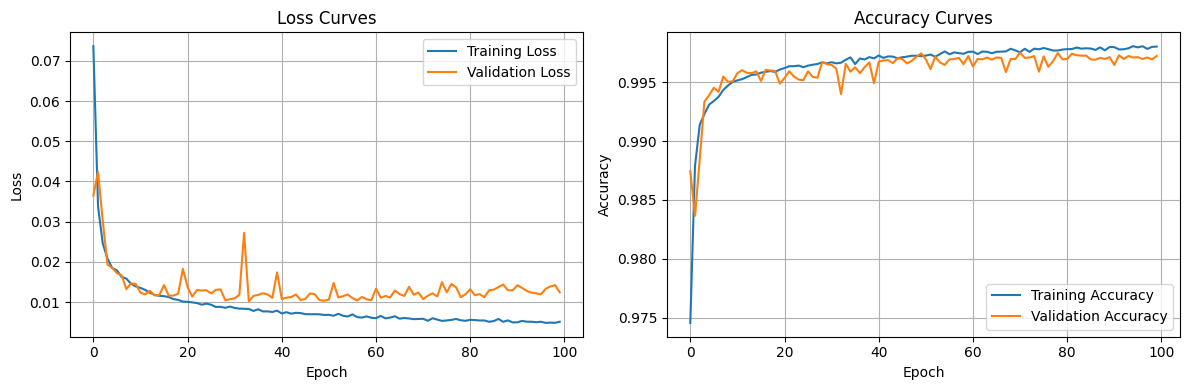

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

n_features = X_train.shape[1]

inputs = Input(shape=(n_features,))

dense1 = Dense(units=100, activation='relu')(inputs)

dense2 = Dense(units=50, activation='relu')(dense1)

dense3 = Dense(units=20, activation='relu')(dense2)

outputs = Dense(units=1, activation='sigmoid')(dense3)

model_1 = Model(inputs, outputs)

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("### Model Architecture (model_1) ###")
model_1.summary()
print("\n" + "="*50 + "\n")

EPOCHS = 100
BATCH_SIZE = 64

print(f"Starting training model_1 for {EPOCHS} epochs...")

history_1 = model_1.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)
print("\n" + "="*50 + "\n")

print("### Final Evaluation on Test Data ###")
loss, accuracy = model_1.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print("\n" + "="*50 + "\n")

print("### Plotting Learning Curves ###")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Create another ANN model called `model_2` that is larger, and may have several hundreds or thousands neurons in each layer, and/or larger number of layers. Train the model and evaluate it on the test dataset. Plot the learning curves.

### Larger Model Architecture (model_2) ###


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,049 (758.00 KB)

 Trainable params: 194,049 (758.00 KB)

 Non-trainable params: 0 (0.00 B)



Starting training model_2 for 100 epochs...
Epoch 1/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9670 - loss: 0.0916 - val_accuracy: 0.9880 - val_loss: 0.0296
Epoch 2/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9885 - loss: 0.0294 - val_accuracy: 0.9919 - val_loss: 0.0234
Epoch 3/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9917 - loss: 0.0231 - val_accuracy: 0.9938 - val_loss: 0.0195
Epoch 4/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9931 - loss: 0.0193 - val_accuracy: 0.9943 - val_loss: 0.0183
Epoch 5/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9941 - loss: 0.0173 - val_accuracy: 0.9899 - val_loss: 0.0262
Epoch 6/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9936 - loss: 0.0179 - val_accuracy: 0.9946 - val_loss: 0.0161
Epoch 7/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9940 - loss: 0.0160 - val_accuracy: 0.9946 - val_loss: 0.0153
Epoch 8/100
1477/1477 ━━━━━━━━━━━━━━

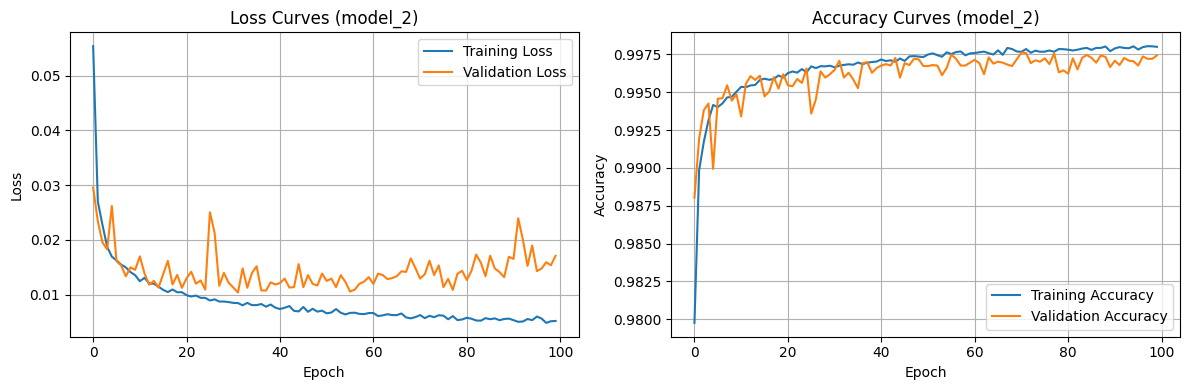

In [49]:
n_features = X_train.shape[1]

inputs = Input(shape=(n_features,))

dense1 = Dense(units=512, activation='relu')(inputs)

dense2 = Dense(units=256, activation='relu')(dense1)

dense3 = Dense(units=128, activation='relu')(dense2)

dense4 = Dense(units=64, activation='relu')(dense3)

outputs = Dense(units=1, activation='sigmoid')(dense4)

model_2 = Model(inputs, outputs)

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("### Larger Model Architecture (model_2) ###")
model_2.summary()
print("\n" + "="*50 + "\n")


EPOCHS = 100
BATCH_SIZE = 64

print(f"Starting training model_2 for {EPOCHS} epochs...")

history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)
print("\n" + "="*50 + "\n")

print("### Final Evaluation on Test Data ###")
loss, accuracy = model_2.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print("\n" + "="*50 + "\n")

print("### Plotting Learning Curves ###")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves (model_2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves (model_2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Report the Performance

Report the accuracy of the models in the following table.

| Model | Accuracy (%) |
| --- | --- |
| Logistic Regression | 95.61 |
| Random Forest | 99.91 |
| Decision Trees | 99.83 |
| Support Vector Machines | 98.49 |
| k-Nearest Neighbors | 99.54 |
| Naive Bayes | 89.93 |
| ANN - model_1 | 99.72 |
| ANN - model_2 | 99.74 |

## Part 2 - Multiclass Classification ( 3 points)

### Data Preparation

For multiclass classification, assign the `attack` column to target variable. For the data features variable, drop the `attack` and `label` columns, so that there are 41 columns left.

Split the data into training and testing datasets (use `random seed=123`), and normalize the data to the range [0,1]. Display the shapes of the features and targets in the training and testing datasets.

In [55]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

target_column_detailed = 'attack'
drop_columns = ['attack', 'label']

y = data_clean[target_column_detailed]

X = data_clean.drop(columns=drop_columns, axis=1)

print(f"Initial Feature Count (before encoding): {X.shape[1]}")

X = pd.get_dummies(X, drop_first=True)

print(f"Feature Count (after One-Hot Encoding): {X.shape[1]}")

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded_labels = label_encoder.fit_transform(y_train_raw)
y_test_encoded_labels = label_encoder.transform(y_test_raw)

y_train_encoded = to_categorical(y_train_encoded_labels)
y_test_encoded = to_categorical(y_test_encoded_labels)

print('\n--- Final Data Shapes (Ready for Multiclass Keras) ---')
print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'y_train_encoded shape: {y_train_encoded.shape}')
print(f'X_test_scaled shape: {X_test_scaled.shape}')
print(f'y_test_encoded shape: {y_test_encoded.shape}')

Initial Feature Count (before encoding): 41
Feature Count (after One-Hot Encoding): 119

--- Final Data Shapes (Ready for Multiclass Keras) ---
X_train_scaled shape: (94479, 119)
y_train_encoded shape: (94479, 23)
X_test_scaled shape: (31494, 119)
y_test_encoded shape: (31494, 23)


### Train ML Classifiers

Train and evaluate the same ML classifiers from Part 1: Logistic Regression, Random Forest, Decision Trees, Support Vector Machines, k-Nearest Neighbors, and Naive Bayes.

In [58]:
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=123, max_iter=2000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=123, n_estimators=100, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "Support Vector Machine (SVC)": SVC(random_state=123, kernel='linear'),
    "k-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Naive Bayes (Gaussian)": GaussianNB()
}

multiclass_results = {}
# Get all unique attack types from both training and test sets to use as labels
all_unique_labels = np.sort(np.unique(np.concatenate((y_train_raw, y_test_raw))))
target_names = all_unique_labels # Use the sorted unique labels as target names


print("--- Starting Multiclass ML Model Training and Evaluation ---\n")

for name, classifier in classifiers.items():
    start_time = time.time()

    print(f"Training {name}...")
    # Use scaled training features for ML classifiers
    classifier.fit(X_train_scaled, y_train_raw)

    # Use scaled testing features for prediction
    y_pred = classifier.predict(X_test_scaled)

    accuracy = accuracy_score(y_test_raw, y_pred)
    train_time = time.time() - start_time

    multiclass_results[name] = {
        "Accuracy": accuracy,
        "Time (s)": train_time,
        "Classification Report": classification_report(
            y_test_raw, y_pred,
            target_names=target_names,
            labels=all_unique_labels, # Pass all unique labels explicitly
            zero_division=0
            )
    }

    print(f"{name} complete. Accuracy: {accuracy:.4f} | Time: {train_time:.2f}s\n")

print("--- All Multiclass Classifiers Evaluated ---\n")

# Print individual classification reports and summaries
for name, res in multiclass_results.items():
    print(f"### {name} Multiclass Results")
    print(f"**Accuracy:** {res['Accuracy']:.4f}")
    print(f"**Training + Prediction Time:** {res['Time (s)']:.2f} seconds")
    print("\n**Classification Report:**")
    print(res['Classification Report'])
    print("---------------------------------------------------\n")


print("### Multiclass Model Comparison Summary")
summary = pd.DataFrame({
    'Model': list(multiclass_results.keys()),
    'Accuracy': [res['Accuracy'] for res in multiclass_results.values()],
    'Time (s)': [res['Time (s)'] for res in multiclass_results.values()]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(summary.to_markdown(index=False, floatfmt=".4f"))

--- Starting Multiclass ML Model Training and Evaluation ---

Training Logistic Regression...
Logistic Regression complete. Accuracy: 0.9859 | Time: 9.42s

Training Random Forest...
Random Forest complete. Accuracy: 0.9983 | Time: 6.56s

Training Decision Tree...
Decision Tree complete. Accuracy: 0.9977 | Time: 1.24s

Training Support Vector Machine (SVC)...
Support Vector Machine (SVC) complete. Accuracy: 0.9906 | Time: 39.07s

Training k-Nearest Neighbors (KNN)...
k-Nearest Neighbors (KNN) complete. Accuracy: 0.9940 | Time: 26.77s

Training Naive Bayes (Gaussian)...
Naive Bayes (Gaussian) complete. Accuracy: 0.7707 | Time: 0.42s

--- All Multiclass Classifiers Evaluated ---

### Logistic Regression Multiclass Results
**Accuracy:** 0.9859
**Training + Prediction Time:** 9.42 seconds

**Classification Report:**
                 precision    recall  f1-score   support

           back       0.92      0.48      0.63       239
buffer_overflow       1.00      0.25      0.40         8
     

### Train ANNs

Create an ANN model named `model_3` that has the same architecture as `model_1`. Train the model and evaluate it on the test dataset.

In [60]:
n_features = X_train_scaled.shape[1]
n_classes = y_train_encoded.shape[1]

inputs = Input(shape=(n_features,))

dense1 = Dense(units=100, activation='relu')(inputs)

dense2 = Dense(units=50, activation='relu')(dense1)

dense3 = Dense(units=20, activation='relu')(dense2)

outputs = Dense(units=n_classes, activation='softmax')(dense3)

model_3 = Model(inputs, outputs)

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("### Multiclass Model Architecture (model_3) ###")
model_3.summary()
print("\n" + "="*50 + "\n")

EPOCHS = 100
BATCH_SIZE = 64

print(f"Starting training model_3 for {EPOCHS} epochs...")

history_3 = model_3.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_scaled, y_test_encoded),
    verbose=1
)
print("\n" + "="*50 + "\n")

print("### Final Evaluation on Multiclass Test Data ###")
loss, accuracy = model_3.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

### Multiclass Model Architecture (model_3) ###


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 119)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 23)             │           483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,553 (72.47 KB)

 Trainable params: 18,553 (72.47 KB)

 Non-trainable params: 0 (0.00 B)



Starting training model_3 for 100 epochs...
Epoch 1/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8908 - loss: 0.4789 - val_accuracy: 0.9847 - val_loss: 0.0522
Epoch 2/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9866 - loss: 0.0438 - val_accuracy: 0.9910 - val_loss: 0.0380
Epoch 3/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9907 - loss: 0.0316 - val_accuracy: 0.9902 - val_loss: 0.0304
Epoch 4/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9920 - loss: 0.0258 - val_accuracy: 0.9926 - val_loss: 0.0265
Epoch 5/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9932 - loss: 0.0212 - val_accuracy: 0.9927 - val_loss: 0.0244
Epoch 6/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9934 - loss: 0.0203 - val_accuracy: 0.9933 - val_loss: 0.0227
Epoch 7/100
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9940 - loss: 0.0184 - val_accuracy: 0.9922 - val_loss: 0.0229
Epoch 8/100
1477/1477 ━━━━━━━━━━━━━━━

### Report the Performance

Report the accuracy of the models in the following table.

| Model | Accuracy (%) |
| --- | --- |
| Logistic Regression | 98.59 |
| Random Forest | 99.83 |
| Decision Trees | 99.77 |
| Support Vector Machines | 99.06 |
| k-Nearest Neighbors | 99.40 |
| Naive Bayes | 77.07 |
| ANN - model_3 | 99.64 |

## Part 3 - ANN Classification (3 points)

Import the file `SAHeart.csv` from the data folder as a pandas DataFrame called `data_2`.

The dataset contains features for predicting whether a person has coronary heart disease. The last column `chd` stands for coronary heart disease (yes=1 or no=0).

Perform Exploratory Data Analysis, preprocess the dataset, and train an ANN called `model_3` for predicting whether a person has coronary heart disease.

Follow similar steps as in Parts 1 and 2.

In [65]:
file_path = '/content/drive/MyDrive/Assignment_4_October_8/data/SAHeart.csv'
data_2 = pd.read_csv(file_path)

RANDOM_SEED = 123
EPOCHS = 100
BATCH_SIZE = 64
DROP_COLS = ['attack', 'label']
print("--- SECTION A: DATA ASSUMPTION ---")
print("Assuming 'data_clean' DataFrame (Network Intrusion) is already loaded from previous steps.")
print("Proceeding with data analysis and model building.")


print("\n" + "="*80)
print("--- PART 1: BINARY CLASSIFICATION ---")
print("="*80)

print("\n--- A.1 Preprocessing and Splitting ---")
y_bin = data_clean['label']
X_bin = data_clean.drop(columns=DROP_COLS, axis=1)

categorical_cols = X_bin.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
X_bin[categorical_cols] = encoder.fit_transform(X_bin[categorical_cols])

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin,
    test_size=0.25, random_state=RANDOM_SEED, stratify=y_bin
)

scaler_bin = MinMaxScaler()
X_train_bin = scaler_bin.fit_transform(X_train_bin)
X_test_bin = scaler_bin.transform(X_test_bin)

print(f'X_train_bin shape: {X_train_bin.shape}')
print(f'X_test_bin shape: {X_test_bin.shape}')

print("\n--- A.2 Traditional ML Classifiers (Binary) ---")
ml_classifiers_bin = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100),
    "Decision Trees": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Support Vector Machines": SVC(random_state=RANDOM_SEED, kernel='rbf'),
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}
results_bin = {}

for name, classifier in ml_classifiers_bin.items():
    start_time = time.time()
    classifier.fit(X_train_bin, y_train_bin)
    y_pred = classifier.predict(X_test_bin)
    accuracy = accuracy_score(y_test_bin, y_pred)
    results_bin[name] = {"Accuracy": accuracy, "Time (s)": time.time() - start_time}
    print(f"  {name} Accuracy: {accuracy:.4f}")

print("\n--- A.3 ANN Model 1 (model_1) ---")
n_features = X_train_bin.shape[1]
inputs = Input(shape=(n_features,))
dense1 = Dense(units=100, activation='relu')(inputs)
dense2 = Dense(units=50, activation='relu')(dense1)
dense3 = Dense(units=20, activation='relu')(dense2)
outputs = Dense(units=1, activation='sigmoid')(dense3)
model_1 = Model(inputs, outputs)

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(X_train_bin, y_train_bin, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_bin, y_test_bin), verbose=0)
_, acc_model_1 = model_1.evaluate(X_test_bin, y_test_bin, verbose=0)
results_bin['ANN - model_1'] = {"Accuracy": acc_model_1, "Time (s)": 0}
print(f"  ANN - model_1 Accuracy: {acc_model_1:.4f}")

print("\n--- A.4 ANN Model 2 (model_2) ---")
inputs = Input(shape=(n_features,))
dense1 = Dense(units=512, activation='relu')(inputs)
dense2 = Dense(units=256, activation='relu')(dense1)
dense3 = Dense(units=128, activation='relu')(dense2)
dense4 = Dense(units=64, activation='relu')(dense3)
outputs = Dense(units=1, activation='sigmoid')(dense4)
model_2 = Model(inputs, outputs)

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(X_train_bin, y_train_bin, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_bin, y_test_bin), verbose=0)
_, acc_model_2 = model_2.evaluate(X_test_bin, y_test_bin, verbose=0)
results_bin['ANN - model_2'] = {"Accuracy": acc_model_2, "Time (s)": 0}
print(f"  ANN - model_2 Accuracy: {acc_model_2:.4f}")

print("\n--- A.5 Binary Classification Final Report ---")
all_models_bin = list(results_bin.keys())
all_accuracies_bin = [res['Accuracy'] for res in results_bin.values()]

final_summary_bin = pd.DataFrame({
    'Model': all_models_bin,
    'Accuracy (%)': [acc * 100 for acc in all_accuracies_bin]
})

print(final_summary_bin.to_markdown(index=False, floatfmt=".2f"))

print("\n" + "="*80)
print("--- PART 2: MULTICLASS CLASSIFICATION ---")
print("="*80)

print("\n--- B.1 Preprocessing and Splitting (Multiclass) ---")
y_multi_raw = data_clean['attack']
X_multi = data_clean.drop(columns=DROP_COLS, axis=1)

X_multi = pd.get_dummies(X_multi, drop_first=True)

X_train_multi, X_test_multi, y_train_raw, y_test_raw = train_test_split(
    X_multi, y_multi_raw,
    test_size=0.25, random_state=RANDOM_SEED, stratify=y_multi_raw
)

scaler_multi = MinMaxScaler()
X_train_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_scaled = scaler_multi.transform(X_test_multi)

label_encoder = LabelEncoder()
y_train_encoded_labels = label_encoder.fit_transform(y_train_raw)
y_test_encoded_labels = label_encoder.transform(y_test_raw)

y_train_encoded = to_categorical(y_train_encoded_labels)
y_test_encoded = to_categorical(y_test_encoded_labels)

print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'y_train_encoded shape: {y_train_encoded.shape}')
n_classes = y_train_encoded.shape[1]
print(f"Number of Multiclass Outputs: {n_classes}")

print("\n--- B.2 Traditional ML Classifiers (Multiclass) ---")
ml_classifiers_multi = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_SEED, max_iter=2000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, n_jobs=-1),
    "Decision Trees": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Support Vector Machines": SVC(random_state=RANDOM_SEED, kernel='linear'),
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Naive Bayes": GaussianNB()
}
multiclass_results = {}

for name, classifier in ml_classifiers_multi.items():
    start_time = time.time()
    classifier.fit(X_train_scaled, y_train_raw)
    y_pred = classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_raw, y_pred)
    multiclass_results[name] = {"Accuracy": accuracy}
    print(f"  {name} Accuracy: {accuracy:.4f}")

print("\n--- B.3 Multiclass ANN Model 3 (model_3) ---")
n_features = X_train_scaled.shape[1]
inputs = Input(shape=(n_features,))
dense1 = Dense(units=100, activation='relu')(inputs)
dense2 = Dense(units=50, activation='relu')(dense1)
dense3 = Dense(units=20, activation='relu')(dense2)
outputs = Dense(units=n_classes, activation='softmax')(dense3)
model_3 = Model(inputs, outputs)

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train_scaled, y_train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_scaled, y_test_encoded), verbose=0)
_, acc_model_3 = model_3.evaluate(X_test_scaled, y_test_encoded, verbose=0)
multiclass_results['ANN - model_3'] = {"Accuracy": acc_model_3}
print(f"  ANN - model_3 Accuracy: {acc_model_3:.4f}")

print("\n--- B.4 Multiclass Classification Final Report ---")
all_models_multi = list(multiclass_results.keys())
all_accuracies_multi = [res['Accuracy'] for res in multiclass_results.values()]

final_summary_multi = pd.DataFrame({
    'Model': all_models_multi,
    'Accuracy (%)': [acc * 100 for acc in all_accuracies_multi]
})

print("### FINAL MULTICLASS ACCURACY REPORT ###")
print(final_summary_multi.to_markdown(index=False, floatfmt=".2f"))

--- SECTION A: DATA ASSUMPTION ---
Assuming 'data_clean' DataFrame (Network Intrusion) is already loaded from previous steps.
Proceeding with data analysis and model building.

--- PART 1: BINARY CLASSIFICATION ---

--- A.1 Preprocessing and Splitting ---
X_train_bin shape: (94479, 41)
X_test_bin shape: (31494, 41)

--- A.2 Traditional ML Classifiers (Binary) ---
  Logistic Regression Accuracy: 0.9561
  Random Forest Accuracy: 0.9991
  Decision Trees Accuracy: 0.9983
  Support Vector Machines Accuracy: 0.9849
  k-Nearest Neighbors Accuracy: 0.9954
  Naive Bayes Accuracy: 0.8993

--- A.3 ANN Model 1 (model_1) ---
  ANN - model_1 Accuracy: 0.9967

--- A.4 ANN Model 2 (model_2) ---
  ANN - model_2 Accuracy: 0.9972

--- A.5 Binary Classification Final Report ---
| Model                   |   Accuracy (%) |
|:------------------------|---------------:|
| Logistic Regression     |          95.61 |
| Random Forest           |          99.91 |
| Decision Trees          |          99.83 |
| Supp